## An Introduction to Open Quantum System Dynamics using pyTTN

TODO: Fix links throughout

In this quickstart guide, we demonstrate how to use pyTTN to perform basic open quantum system (OQS) calculations using Tree Tensor Network state ansatz for the state vector.  Here we focus on applications to the spin-boson model and demonstrate how the `pyTTN.oqs` module can be used to easily set up a range of OQS simulation techniques, namely:

1. [The Discretised Star Hamiltonian](#dynamics-using-the-star-hamiltonian)

2. [The (T-)TEDOPA Method](#dynamics-using-the-tedopa-method)

3. [The Hierarchical Equations of Motion]()

4. [The Generalised Pseudomode Method]()

However, before performing the dynamics of the system we will briefly discuss some of the Open Quantum System specific features present in pyTTN. t

### Contents


1. [ Handling Continuous Bosonic Baths](#handling-continuous-bosonic-baths)

    - [Importing the Library](#importing-the-library)

    - [Continuous Bosonic Baths](#continuous-bosonic-baths)

    - [Bath Correlation Functions](#bath-correlation-functions)

    - [Discretise Baths](#discretise-baths)

    - [Sum-of-Exponential Baths](#sum-of-exponential-fit-Baths)

2. [Dynamics using the Discretised Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian)

    - [Import The Library]()
    
    - [Setting up the Discrete Bosonic Bath](#setting-up-the-discrete-bosonic-bath)
    
    - [Setting up the System Information](#setting-up-the-system-information)
    
    - [Building the Hamiltonian](#building-the-hamiltonian)
    
    - [Building the Wavefunction](#building-the-wavefunction)
    
    - [Preparing for Time Evolution](#preparing-for-time-evolution)
    
    - [Performing the Time Evolution](#performing-the-time-evolution)

3. [Dynamics using the TEDOPA Method]()

4. [Dynamics using Non-Unitary Dynamics Methods](#dynamics-using-non-unitary-approaches)

### Handling Continuous Bosonic Baths

##### Importing the Library

The first step of any pyTTN calculation is to import the Library.  For Open Quantum system calculations we will also want to import the `pyTTN.oqs` submodule as it provides several useful tools for easily setting up these calculations.


In [188]:
import os
os.environ['OMP_NUM_THREADS']='1'

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

#import jit

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

##### Continuous Bosonic Baths

Now that we have imported the library we can begin setting up the OQS system information.  Here we will consider the case of a Gaussian bosonic bath, with a thermal Gaussian Initial configuration.  In such a case, the influence of the bath on the system dynamics is entirely encoded in the bath Spectral function

- At zero temperature, $S(\omega) = J(\omega) \quad \forall \, \omega > 0$

- At finite temperature, $S(\omega) = \frac{1}{2} J(\omega) \left( 1 + \frac{1}{\text{tanh}(\frac{\beta \omega}{2})} \right)$

where $J(\omega)$ is the bath spectral density, and encodes all information about the bath frequencies and coupling constants. In this example, we will consider a spectral density of the form:

$$
J(\omega) = \text{sign}(\omega) \frac{\pi}{2}\alpha\omega_c \left(\frac{\omega}{\omega_c}\right)^s e^{-|\omega/\omega_c|}
$$.

where $\alpha$ is the Kondo parameter, $\omega_c$ is the cutoff frequency, and $s$ controls the low-frequency dependence of the bath.  We start by defining the bath spectral density function:  

In [189]:
#set up the bath spectral density
alpha = 1.25
s = 1
wc = 5

# Exponential cutoff spectral density
#@jit(nopython=True)
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)


Within pyTTN, the `pyttn.oqs.BosonicBath` class has been provided for handling the spectral function of bosonic baths at both zero and finite temperature, and importantly wraps many of the core operations we would want to perform on such an object, e.g
    - Computing the corresponding bath correlation function
    - Evaluating a discrete bath that efficiently represents the influence of the bath on the system dynamics
    - Performing a sum-of-exponentials fit of the bath correlation function for use with pseudomode/HEOM methods.

We may construct a zero temperature bath using:

In [190]:
#build the bosonic bath with temperature T=0
bath_zero_T = oqs.BosonicBath(J, beta=None)

Alternatively, we can create a finite temperature bath object by setting the inverse temperature $\beta=1/T$ as follows:

In [191]:
#build the bosonic bath with temperature T=1
T=1
bath_finite_T = oqs.BosonicBath(J, beta=1/T)

#### Bath Correlation Functions

We can now readily compute the bath correlation functions using these `pyttn.oqs.BosonicBath` objects giving:

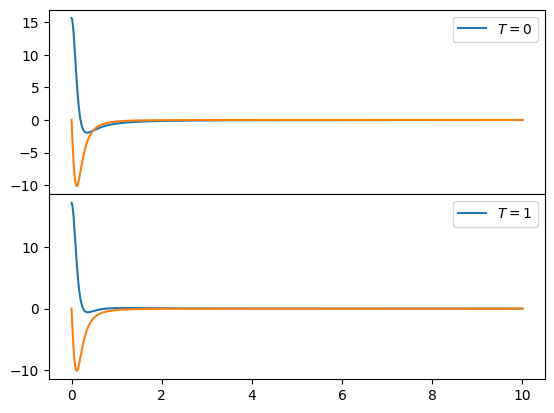

In [192]:
t = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

Ct0 = bath_zero_T.Ct(t)
ax[0].plot(t, np.real(Ct0), label=r"$T=0$")
ax[0].plot(t, np.imag(Ct0))

Ct1 = bath_finite_T.Ct(t)
ax[1].plot(t, np.real(Ct1), label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1))

ax[0].legend()
ax[1].legend()

plt.show()

The `pyttn.oqs.BosonicBath` object also contains several functions for constructing alternative representations of the bath needed for unitary dynamics, and pseudomode/HEOM dynamics simulations.  



#### Discrete Baths

For unitary dynamics, we need to obtain a set of discrete bath frequencies and coupling constants defining a closed system bath that approximates the influence of the full open quantum system bath.  Within pyTTN, several methods have been provided for doing so, for details see the `pyttn.oqs.bath_fitting.bath_discretisation.py`.  When working with finite temperature baths, pyTTN will make use of the thermofields doubles approach to map the finite temperature problem onto the zero temperature dynamics of an effective temperature dependent Hamiltonian.  Here, we will demonstrate the use of the orthonormal polynomial based discretisation scheme (`pyttn.oqs.OrthopolDiscretisation`):

In [193]:
Nb = 128
Nw = 10    
#discretise the zero temperature bath
g0,w0 = bath_zero_T.discretise(oqs.OrthopolDiscretisation(Nb, bath_zero_T.find_wmin(Nw*wc), Nw*wc))

#discretise the finite temperature bath
g1,w1 = bath_finite_T.discretise(oqs.OrthopolDiscretisation(Nb, bath_finite_T.find_wmin(Nw*wc), Nw*wc))

Here we have discretised the two baths, obtaining coupling constants $g$ and frequencies $\omega$ for each bath, using a total of $N_b=128$ bath modes, and have included frequencies up to $10 \omega_c$ when performing the discretisation process.  While these frequencies and coupling constants fully define the discrete bath, there are a few steps needed in order to actually use these within a simulation, namely:
    - Setting up system information objects
    - Truncating the Hilbert space dimension of each of the bosonic modes
    - Construction the system-bath coupling Hamiltonian
    - Setting up the Tree Structure to use for the simulation

 To help simplify this process, pyTTN includes the `pyttn.oqs.DiscreteBosonicBath` class that provides a set of function to significantly simplify each of these processes.  These steps will be explored in more detail below.  Here we will just set up a discrete bath object and use it to plot the discrete bath correlation function.

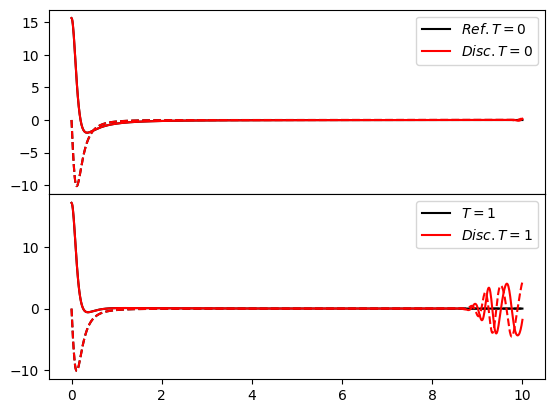

In [194]:
disc_bath_zero_T = oqs.DiscreteBosonicBath(g0, w0)
disc_bath_finite_T = oqs.DiscreteBosonicBath(g1, w1)

Ctd0 = disc_bath_zero_T.Ct(t)
Ctd1 = disc_bath_finite_T.Ct(t)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

#plot the bath correlation functions
Ct0 = bath_zero_T.Ct(t)
ax[0].plot(t, np.real(Ct0), 'k', label=r"$Ref. T=0$")
ax[0].plot(t, np.imag(Ct0), 'k--')
ax[0].plot(t, np.real(Ctd0), 'r', label=r"$Disc. T=0$")
ax[0].plot(t, np.imag(Ctd0), 'r--')

Ct1 = bath_finite_T.Ct(t)
ax[1].plot(t, np.real(Ct1), 'k', label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1), 'k--')
ax[1].plot(t, np.real(Ctd1), 'r', label=r"$Disc. T=1$")
ax[1].plot(t, np.imag(Ctd1), 'r--')

ax[0].legend()
ax[1].legend()

plt.show()

Here we observe excellent agreement of the bath correlation functions at short time, however, at longer times oscillations appear in the discretised baths.  These features can be removed by further increasing the number of modes used to discretise the bath (or reducing the band-width over which the bath spectral density is fit).

#### Sum-of-Exponential Baths

For non-unitary dynamics methods (e.g. pseudomode and HEOM), an alternative representation of the bath is employed, namely a sum-of-exponential decomposition of the bath correlation function.  Within pyTTN, several methods have been provided for doing so, for details see the `pyttn.oqs.bath_fitting.expfit.py` for more details. Here, we will demonstrate the use of the ESPRIT method (`pyttn.oqs.ESPRITDecomposition`) for doing so:

In [195]:
#specify the time step information used in the ESPRIT fitting
dt = 0.05
tmax = 15
nstep = int(tmax/dt)+1    

#specify the number of terms in the sum-of-exponential fit
K=6

#fit the zero and finite temperature baths
dk0, zk0 = bath_zero_T.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))
dk1, zk1 = bath_finite_T.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))

Here we have performed the sum-of-exponential fit for the two baths, obtaining coefficient constants $dk$ and decay rates $zk$ for each bath, using a total of $K=6$ terms in the decomposition.  As in the unitary case, there are still a few steps needed inorder to use these coefficient in a simulation.

 To help simplify this process, pyTTN includes the `pyttn.oqs.ExpFitBosonicBath` class that provides a set of function to significantly simplify each of the process of setting up dynamics simulations.  These steps will be explored in more detail below.  Here we will just set up a ExpFit bath object and use it to plot the discrete bath correlation function.

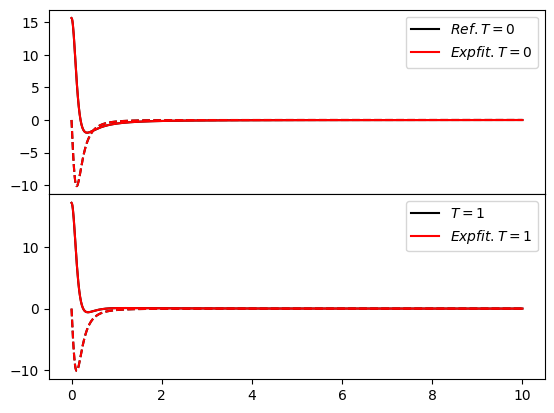

In [196]:
expfit_bath_zero_T = oqs.ExpFitBosonicBath(dk0, zk0)
expfit_bath_finite_T = oqs.ExpFitBosonicBath(dk1, zk1)

Ctd0 = expfit_bath_zero_T.Ct(t)
Ctd1 = expfit_bath_finite_T.Ct(t)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

#plot the bath correlation functions
Ct0 = bath_zero_T.Ct(t)
ax[0].plot(t, np.real(Ct0), 'k', label=r"$Ref. T=0$")
ax[0].plot(t, np.imag(Ct0), 'k--')
ax[0].plot(t, np.real(Ctd0), 'r', label=r"$Expfit. T=0$")
ax[0].plot(t, np.imag(Ctd0), 'r--')

Ct1 = bath_finite_T.Ct(t)
ax[1].plot(t, np.real(Ct1), 'k', label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1), 'k--')
ax[1].plot(t, np.real(Ctd1), 'r', label=r"$Expfit. T=1$")
ax[1].plot(t, np.imag(Ctd1), 'r--')

ax[0].legend()
ax[1].legend()

plt.show()

Here we observe considerably more efficient reproduction of the bath correlation function, which highlights one of the key advantages of using the non-unitary approaches over unitary approaches for OQS dynamics, namely the typically considerably more compact representation of the influence of the bath on the system for continuous bath spectral densities.

Now that we have had a quick look at some of the tools pyTTN has for setting up and handling gaussian bosonic baths, we will now present several examples showing how pyTTN can be used to simulate the dynamics of OQS using a range of different methods.

### Dynamics Using the Discretised Star Hamiltonian



We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using unitary dynamics methods and the standard star topology form of the spin-boson model.  

##### Contents

1. [Import The Library]()

2. [Setting up the Discrete Bosonic Bath](#setting-up-the-discrete-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Hamiltonian](#building-the-hamiltonian)

5. [Building the Wavefunction](#building-the-wavefunction)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

##### Importing the Library

We start by importing the required modules:

In [197]:
import os
os.environ['OMP_NUM_THREADS']='1'

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

##### Setting up the Discrete Bosonic Bath

Next we define the spectral density of the bath and set up the `pyttn.oqs.BosonicBath` and `pyttn.oqs.DiscreteBosonicBath` objects.

In [198]:
#set up the time evolution information
dt = 0.05
tmax = 15
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5

# Exponential cutoff spectral density
#@jit(nopython=True)
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the BosonicBath
bath = oqs.BosonicBath(J, beta=None)

#maximum frequency cutoff upper bound in units of wc
Nw = 8

#discretise the bath using 256 modes 
Nb = 256
g, w = bath.discretise(oqs.OrthopolDiscretisation(Nb, bath_zero_T.find_wmin(Nw*wc), Nw*wc))
discbath = oqs.DiscreteBosonicBath(g, w)


Now we check the quality of the bath correlation function discretisation over the time-period of interest

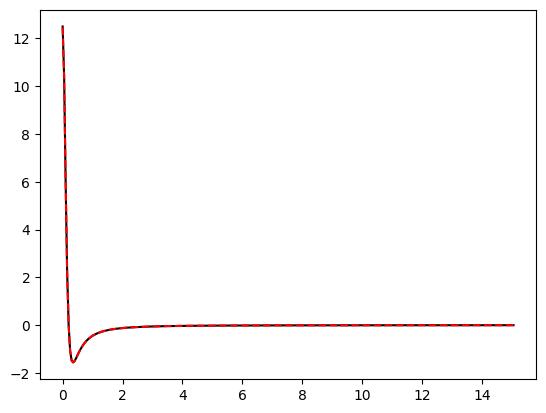

In [199]:
#and check the accuracy of the bath correlation function
plt.plot(t, np.real(bath.Ct(t)), 'k')
plt.plot(t, np.real(discbath.Ct(t)), 'r--')
plt.show()

##### Setting up the System Information

Now we get the system information from the `pyttn.oqs.DiscreteBosonicBath` object, optionally applying mode combination to combine primitive bosonic modes into composite modes.

In [ ]:
#set up the total system information object including both system information and bath information
#here the system consists of a single two level system
sysinf = pyttn.system_modes(1)
sysinf[0] = pyttn.tls_mode()

nbose = 25
discbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=nbose, Lmin=4))

use_mode_combination = True
if use_mode_combination:
    #here we allow for the combination of up to four modes provided the resultant composite Hilbert space dimension has size less than 1000
    nbmax=4
    nhilbmax=1000
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = discbath.system_information(mode_comb)
else:
    bsys = discbath.system_information()

#now combine the system and bath information together
sysinf = pyttn.combine_systems(sysinf, bsys)


##### Building the Hamiltonian

In order to simplify construction of the discrete bath Hamiltonian, the discrete bath function contains the `add_system_bath_hamiltonian` and `system_bath_hamiltonian` functions that, respectively, append to the system-bath Hamiltonian terms to an existing `SOP` object or return a new `sSOP` object containing all system-bath Hamiltonian terms.  

In [201]:
#create the SOP object
H = pyttn.SOP(Nb+1)

#add on the system Hamiltonian
delta = 0.5
eps = 0
H += delta * pyttn.sOP("sx", 0) + eps * pyttn.sOP("sz", 0)

#and append all bath and system bath Hamiltonian terms
H = discbath.add_system_bath_hamiltonian(H, pyttn.sOP("sz", 0), geom="star")

Both the `add_system_bath_hamiltonian` and `system_bath_hamiltonian` objects can take a set of user defined indices corresponding to the bath modes (passed as the `binds` argument).  If this argument is not set, the function will assume that all bath modes are in a contiguous block starting at `bskip` which defaults to 1.  

Note: Care must be taken when defining the `binds` argument in conjunction with the use of mode_combination.  In the current release, pyTTN expects all composite modes to be formed of contiguous `primitive_modes`.

##### Building the Wavefunction

We are now in a position to prepare the wavefunction tree topology.  Here, again, the `pyttn.oqs.DiscreteBosonicBath` class can help through the `add_bath_tree` function, which takes a node in an existing tree used to represent the system degrees of freedom and attaches either an MPS or balanced N-ary tree to represent the degrees of freedom handled by the discbath object.  

To build the tree, we first define the tree structure for system degrees of freedom, then attach the bath tree in the correct position.

In [202]:
#bond dimension used at start of simulation
chi0 = 4

#maximum allowed bond dimension in network
chi = 32

#the degree of the bath tree.  
#   degree=1 => MPS
#   degree>1 => balanced degree-ary tree
degree = 2

#set up the topology tree
topo = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(topo(), degree, chi0, chi0)

#set up the capacity tree
capacity = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(capacity(), degree, chi, chi)

Note: For the case we are considering here this inserts the bath nodes in such a way that they agree with the ordering in the Hamiltonian.  In general, the ordering of modes in the tree structure is determined by their traversal order using a pre-order depth-first search traversal.  For more complex use cases, it may become necessary to set the `system_modes.mode_indices` variable of the `sysinf` object that specifies how composite mode indices in the Hamiltonian in the Hamiltonian should be mapped to indices in the tree structure.


Now that we have constructed the tree topology, we can build the actually TTN wavefunction.  For standard OQS simulations, in which we perform dynamics from a state corresponding to an initially uncorrelated system-bath density operator, with a thermal (or vacuum) bath (dependent on temperature), the initial configuration of the bath for these unitary dynamics simulations is simply the vacuum state (at finite temperature this is due to the fact that we have used the thermofield mapping to construct a new model where the zero-temperature dynamics reproduces the finite-temperature dynamics of our original mode).  As such, creation of the initial wavefunction is straightfoward

In [203]:
#build the TTN object for this system
A = pyttn.ttn(topo, capacity, dtype=np.complex128)

#prepare a product state where the system is in the up spin state (0) and the bath is in its vacuum state
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state) 

##### Preparing for Time Evolution

Now the final steps before preparing for the time-evolution are to:

1. set up time evolution parameters
2. construct the `sop_operator` representation.  Here we will use the hierarchical SOP representation of the Hamiltonian as it leads to considerable performance improvements compared to the SOP representation.
3. setup any observables of interest for the system.  Here, we will look at the magnetisation of the spin throughout the dynamics process, and so will set up a site_operator object to allow for evaluation of this quantity.
4. setup the `matrix_element` object used to evaluate expectation values.
5. create the `tdvp` object for time evolution.  Here we will use the adaptive one-site algorithm for time-evolution.

In [204]:
#set up the Hamiltonian as a sop_operator object
h = pyttn.sop_operator(H, A, sysinf)

#set up the observable to measure
op = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#construct matrix_element object need for evaluating observables
mel = pyttn.matrix_element(A)

#prepare the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim=16, subspace_neigs = 4, subspace_krylov_dim = 8, expansion='subspace')
sweep.spawning_threshold = 1e-8
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

##### Performing the Time Evolution

Now that everything is set up we are in a position where we can perform each of the time-evolution steps and measure the observables of interest. 

 Here we make use of a little trick for improving the accuracy of the time-evolution at short time. For systems initially in the product state, the ttn wavefunction represents a rather constrained manifold, and the dynamics can depend strongly on the choice of initially unoccupied basis functions.  To alleviate this, it can be useful to perform small steps initially in order to allow for these unoccupied functions to evolve partially under the Hamiltonian of the system before too much damage has been done to the wavefunction.  As shown in Ref., this can dramatically improve the accuracy of the TDVP calculations with only very modest additional computational cost.

In [205]:
#measure the initial magnetisation
Sz[0] = np.real(mel(op, A, A))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]
i=1

Now that we have completed the first step, we return to time evolution as usual.

In [206]:
#set the values after the first timestep
Sz[i] =np.real(mel(op, A, A))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(op, A, A))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

And now that we have finished the time evolution we can plot the resultant magnetisation.

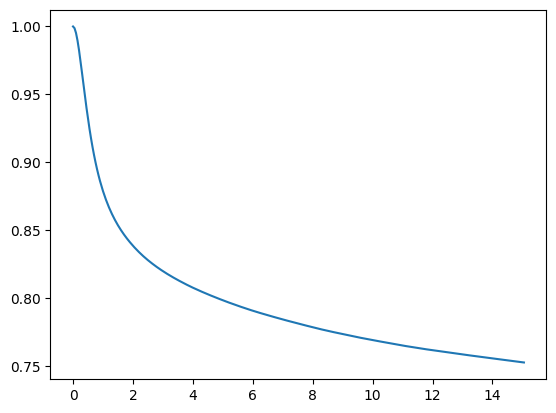

In [207]:
plt.plot(t, Sz)
plt.show()

And we can also do things like visualise how the bond dimension has expanded throughout the tensor network.

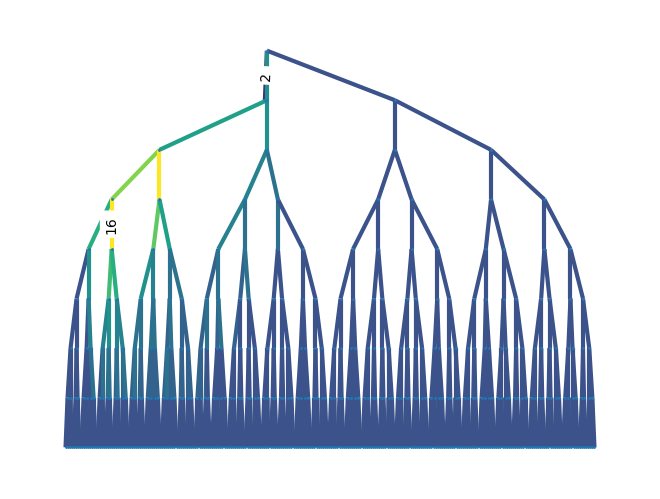

In [208]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()

### Dynamics using the TEDOPA Method



We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using the TEDOPA method.  This approaoch is also a unitary Dynamics approach, but with two main difference from the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example:

1. The use of an MPS ansatz for the bath contribution to the wavefunction
2. The use of the Chain Topology form of the system-bath Hamiltonian

Within the pyTTN library, both the construction of the bath contribution to the wavefunction and the definition of the system-bath Hamiltonian are controlled by the `pyttn.oqs.DiscreteBosonicBath` function, and as a result we may perform TEDOPA simulations of the above model with only two minor changes to the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example.  

##### Contents

1. [Import The Library]()

2. [Setting up the Discrete Bosonic Bath](#setting-up-the-discrete-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Hamiltonian](#building-the-hamiltonian)

5. [Building the Wavefunction](#building-the-wavefunction)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

##### Importing the Library

We start by importing the required modules.  This is unchanged from the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example.

In [209]:
import os
os.environ['OMP_NUM_THREADS']='1'

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

##### Setting up the Discrete Bosonic Bath

Next we define the spectral density of the bath and set up the `pyttn.oqs.BosonicBath` and `pyttn.oqs.DiscreteBosonicBath` objects.

 This is unchanged from the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example.

In [237]:
#set up the time evolution information
dt = 0.05
tmax = 10
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5

# Exponential cutoff spectral density
#@jit(nopython=True)
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the BosonicBath
bath = oqs.BosonicBath(J, beta=None)

#maximum frequency cutoff upper bound in units of wc
Nw = 8

#discretise the bath using 256 modes 
Nb = 140
g, w = bath.discretise(oqs.OrthopolDiscretisation(Nb, bath_zero_T.find_wmin(Nw*wc), Nw*wc))
discbath = oqs.DiscreteBosonicBath(g, w)


##### Setting up the System Information

Now we get the system information from the `pyttn.oqs.DiscreteBosonicBath` object, optionally applying mode combination to combine primitive bosonic modes into composite modes.

 This is unchanged from the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example.

In [ ]:
#set up the total system information object including both system information and bath information
#here the system consists of a single two level system
sysinf = pyttn.system_modes(1)
sysinf[0] = pyttn.tls_mode()

nbose = 25
discbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=nbose, Lmin=4))

use_mode_combination = True
if use_mode_combination:
    #here we allow for the combination of up to four modes provided the resultant composite Hilbert space dimension has size less than 1000
    nbmax=4
    nhilbmax=1000
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = discbath.system_information(mode_comb)
else:
    bsys = discbath.system_information()

#now combine the system and bath information together
sysinf = pyttn.combine_systems(sysinf, bsys)


##### Building the Hamiltonian

Here we see our first change compared to the example provided in [Dynamics](#dynamics-using-the-discretised-star-hamiltonian).  The TEDOPA method makes use of the chain geometry for the system-bath coupling Hamiltonian.  Within pyTTN, the geometry of the system-bath coupling Hamiltonian is controlled by the optional `geom` parameter.

To use the chain representation, we simply set this parameter to "chain".

In [239]:
#create the SOP object
H = pyttn.SOP(Nb+1)

#add on the system Hamiltonian
delta = 0.5
eps = 0
H += delta * pyttn.sOP("sx", 0) + eps * pyttn.sOP("sz", 0)

#and append all bath and system bath Hamiltonian terms
H = discbath.add_system_bath_hamiltonian(H, pyttn.sOP("sz", 0), geom="chain")

##### Building the Wavefunction

We are now in a position to prepare the wavefunction tree topology.  This is where the second and final change from the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example is made.  The TEDOPA method makes use of an MPS tree for representing the bath, this can be enforced by setting `degree=1`.


In [240]:
#bond dimension used at start of simulation
chi0 = 4

#maximum allowed bond dimension in network
chi = 16

#construct the MPS bath tree used for TEDOPA
degree = 1

#set up the topology tree
topo = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(topo(), degree, chi0, chi0)

#set up the capacity tree
capacity = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(capacity(), degree, chi, chi)


At this stage, the script proceeds identically to the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example. 

In [241]:
#build the TTN object for this system
A = pyttn.ttn(topo, capacity, dtype=np.complex128)

#prepare a product state where the system is in the up spin state (0) and the bath is in its vacuum state
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state) 

##### Preparing for Time Evolution

In [242]:
#set up the Hamiltonian as a sop_operator object
h = pyttn.sop_operator(H, A, sysinf)

#set up the observable to measure
op = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#construct matrix_element object need for evaluating observables
mel = pyttn.matrix_element(A)

#prepare the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim=16, subspace_neigs = 4, subspace_krylov_dim = 8, expansion='subspace')
sweep.spawning_threshold = 1e-7
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

##### Performing the Time Evolution

In [ ]:
#measure the initial magnetisation
Sz[0] = np.real(mel(op, A, A))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]

Now that we have completed the first step, we return to time evolution as usual.

In [ ]:
i=1
#set the values after the first timestep
Sz[i] =np.real(mel(op, A, A))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(op, A, A))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

And now that we have finished the time evolution we can plot the resultant magnetisation.

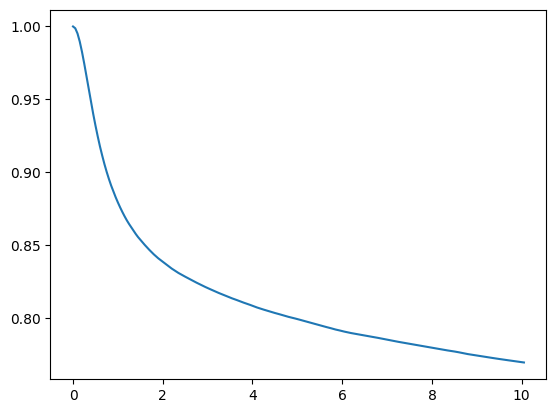

In [245]:
plt.plot(t, Sz)
plt.show()

And we can also do things like visualise how the bond dimension has expanded throughout the tensor network.

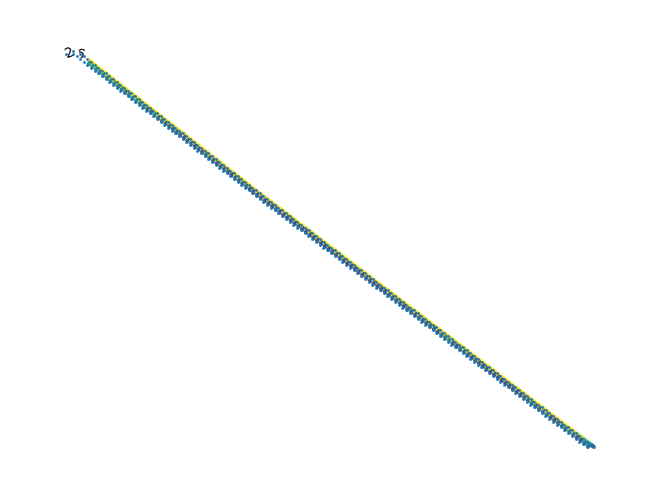

In [246]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()

### Dynamics using Non-unitary Approaches

#### WIP:

We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using the non-unitary dynamics methods, namely the Hierarchical Equations of Motion (HEOM) and Quasi-Lindblad Pseudomode (pseudomode) methods.  In constrast to the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) and [TEDOPA](#dynamics-using-the-tedopa-method) examples, with these approaches we work with density matrices and pseudoboson modes that have in general complex frequency and couple to the system with non-hermitian system-bath coupling terms.    

The two approaches, HEOM and pseudomode, are up to a similarity transformation equivalent, and consequently the process for setting up the two approaches is incredibly similar.  Within pyTTN, this process is simplified through the use of the `pyttn.oqs.ExpFitBosonicBath` class, which similar to the `pyttn.oqs.DiscreteBosonicBath` provides a set of functions allowing or easy set up of non-unitary equation of motion based dynamics methods that make use of a sum-of-exponential decomposition for the bath correlation function. 

In this example, we demonstrate how to perform HEOM calculations for the spin-boson model considered above using pyTTN.  This example can be modified to perform pseudomode dynamics simply by replacing `method="heom"` with `method="pseudomode"`. 

##### Contents

1. [Import The Library]()

2. [Setting up the Expfit Bosonic Bath](#setting-up-the-expfit-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Generator](#building-the-generator)

5. [Building the ADOs Tensor Network](#building-the-ados-tensor-network)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

##### Importing the Library

In [268]:
import os
os.environ['OMP_NUM_THREADS']='1'

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

##### Setting up the Expfit Bosonic Bath

In [269]:
#set the method for the pyttn.oqs.ExpFitBosonicBath object
method = "heom"

#number of modes in decomposition
K = 6

#set up the time evolution information
dt = 0.05
tmax = 15
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5    

#setup the function for evaluating the exponential cutoff spectral density
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the open quantum system bath object
bath = oqs.BosonicBath(J, beta=None)
dk, zk = bath.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))

expbath = oqs.ExpFitBosonicBath(dk, zk)

##### Setting up the System Information

In [270]:
L = 30
Lmin = 4

expbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=L, Lmin=Lmin))

#setup the system information object
sysinf = pyttn.system_modes(1)
sysinf[0] = [pyttn.tls_mode(), pyttn.tls_mode()]

if use_mode_combination:
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = expbath.system_information(mode_comb)
else:
    bsys = expbath.system_information()


#construct the system information object by combining the system information with the bath information
sysinf = pyttn.combine_systems(sysinf, bsys)

##### Building the Generator


In [271]:
#set up parameters for the system
delta = 0.5
eps = 0

#set up the total Hamiltonian
H = pyttn.SOP(sysinf.nprimitive_modes())

#add on the system liouvillian - here we are using that sz^T = sz and "sx^T=sx"
H += (eps*pyttn.sOP("sz", 0) + delta*pyttn.sOP("sx", 0)) - (eps*pyttn.sOP("sz", 1)+delta*pyttn.sOP("sx", 1))
H = expbath.add_system_bath_generator(H, [pyttn.sOP("sz", 0), pyttn.sOP("sz", 1)], method=method)


##### Building the ADOs Tensor Network


In [272]:
#construct the topology and capacity trees used for constructing 
chi0 = 8
chi = 32
degree = 2

topo = pyttn.ntree("(1(4(4)))")
capacity = pyttn.ntree("(1(4(4)))")
linds = expbath.add_bath_tree(topo(), degree, chi0, chi0)
expbath.add_bath_tree(capacity(), degree, chi, chi)

A = pyttn.ttn(topo, capacity, dtype=np.complex128)
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state)


##### Preparing for Time Evolution

In [273]:
h = pyttn.sop_operator(H, A, sysinf)


#set up ttns storing the observable to be measured.  Here these are just system observables
#so we form a tree with the same topology as A but with all bath bond dimensions set to 1
obstree = pyttn.ntree("(1(4(4)))")
expbath.add_bath_tree(obstree(), degree, 1, 1)
id_ttn = pyttn.ttn(obstree, dtype=np.complex128)
id_ttn.set_product([np.identity(2).flatten()] + expbath.identity_product_state(method=method))

szop = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)
mel = pyttn.matrix_element(A)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#set up the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim = 12, expansion='subspace', subspace_neigs = 4, subspace_krylov_dim = 8)
sweep.spawning_threshold = 1e-10
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

##### Performing the Time Evolution

In [274]:
Sz[0] = np.real(mel(szop, A, id_ttn))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]

i=1
#set the values after the first timestep
Sz[i] =np.real(mel(szop, A, id_ttn))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(szop, A, id_ttn))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

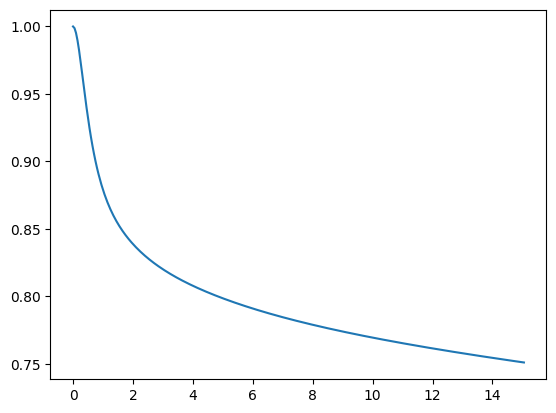

In [275]:
plt.plot(t, Sz)
plt.show()

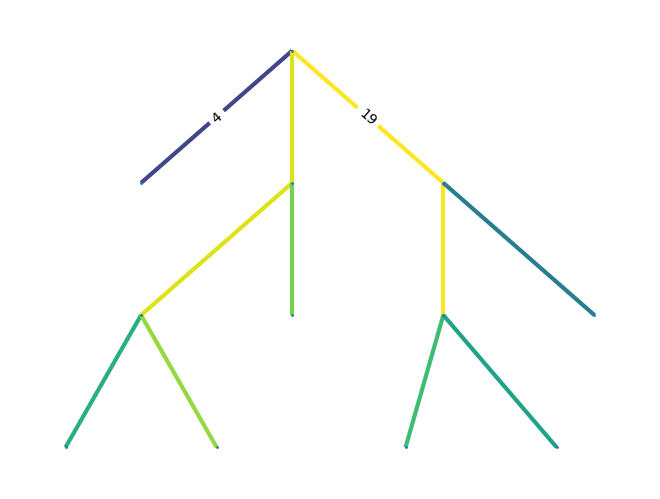

In [276]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()

In [280]:
print(sysinf.mode_dimensions())
print(np.prod(np.array(sysinf.mode_dimensions())))

[4, 900, 900, 256, 36, 16, 16]
7644119040000
